# Tarea individual del módulo 4 - Food 101

 ### Alumno: Dionisio Moreno Cañas

## Librerías

In [1]:
#Aqui se deberian añadir librerias addicionales o eliminar las no necesarias
import os
import time
import random
import pandas as pd
import json
import numpy as np
import mahotas #conda install -c conda-forge mahotas
import cv2 # pip install opencv-python

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve

#Añadidos
from matplotlib import pyplot as plt
import math

import warnings
warnings.filterwarnings('ignore')

### Funciones de ayuda

In [2]:
# path absoluto donde encontrar el dataset elegido 
#https://www.tensorflow.org/datasets/catalog/food101
data_dir = "./datasets/food-101"

# make a fix file size
fixed_size  = tuple((500,500))

#En caso de que necesitemos limitar el numero de imagenes por clase 
max_img_per_label = 1000

#division del dataset  **modificar
percentage_train = 0.90
percentage_test = 0.10


In [3]:
# features description - 1:  Hu Moments
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

# feature-descriptor - 2 Haralick Texture 
def fd_haralick(image):
    # conver the image to grayscale
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    # Ccompute the haralick texture fetature ve tor 
    haralic = mahotas.features.haralick(gray).mean(axis=0)
    return haralic

# feature-description - 3 Color Histogram
def fd_histogram(image, mask=None):
    # bins for histograms 
    bins = 8
    # conver the image to HSV colors-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    #COPUTE THE COLOR HISTPGRAM
    hist  = cv2.calcHist([image],[0,1,2],None,[bins,bins,bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist,hist)
    # return the histog....
    return hist.flatten()

def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f
            
# Load_json function use to read in train.json and test.json
# and only take data according to class_label variable
def load_json(path):
    final_data = dict()
    # Load in json file to create dictionary: key = class label; value = file path
    with open(path, 'r') as file:
        data = json.load(file)
    # Only get information from needed class
    for label in class_label:
        final_data.update({label : data.get(label)})
    return final_data        

# Make a dataframe have all image name and its label
def create_data(json_data, max_img_per_label = 100):
    # Create train data
    file_names_list = []
    label_list = []
    for label in json_data.keys():
        #file_names = os.listdir(data_dir + '/images/' + label)
        file_names = json_data.get(label)
        i = 0
        for file in file_names:
            file = data_dir + '/images/' + file.replace('/', '//') + '.jpg'
            file_names_list.append(file)
            label_list.append(class_label.get(label))
            i += 1
            if i >= max_img_per_label:
                break
    # Create dataframe
    data_df = pd.DataFrame({
        'filename' : file_names_list,
        'label' : label_list
    })
    return data_df

def get_train_df():
    # load json file
    train_json = load_json(data_dir + '/meta/train.json')
    # Create dataframe for train
    train_df = create_data(train_json, max_img_per_label * percentage_train)
    return train_df

def get_test_df():
    # load json file
    train_json = load_json(data_dir + '/meta/test.json')
    # Create dataframe for train
    train_df = create_data(train_json, max_img_per_label * percentage_test)
    return train_df

# get data processing
def getDataProcessing(df):
    train_features = []
    train_labels = []
    i = 0
    print('Start data processing with', len(df), 'images...')
    for currentImgPath in df['filename']:
        # read the image and resize it to a fixed-size
        image = cv2.imread(currentImgPath)
        if image is not None:
            image = cv2.resize(image, fixed_size)
            fv_hu_moments = fd_hu_moments(image)
            fv_haralick   = fd_haralick(image)
            fv_histogram  = fd_histogram(image)
        train_labels.append(df['label'].array[i])
        train_features.append(np.hstack([fv_histogram, fv_haralick, fv_hu_moments]))
        i += 1
    
    print('Data processing finished.')     
    return train_features, train_labels
    
def getKeysByValue(dictOfElements, valueToFind):
    listOfKeys = list()
    listOfItems = dictOfElements.items()
    for item  in listOfItems:
        if item[1] == valueToFind:
            listOfKeys.append(item[0])
    return  listOfKeys


# DATASET Y VARIABLE A MODELAR

Por simplicidad, para el estudio y desarrollo de este ejemplo, vamos a enfocar nuestro problema a la distinción de 2 tipos de dulces (Clasificación binaria). Queremos diferenciar las dos opciones habituales de Andrés a las que recurre como postre.

In [4]:
class_label = {
    "carrot_cake" : 0, 
    "chocolate_cake" : 1
}

Configuramos nuestra ruta del dataset, el % de reparto de nuestros datos para entrenar y testear, así como el tamaño homogéneo para nuestras imágenes.

A continuación, obtenemos el dataset.

In [5]:
# Training
train_data_frame = get_train_df()
train_features, train_labels = getDataProcessing(train_data_frame)

#Test
test_data_frame = get_test_df()
test_features, test_labels = getDataProcessing(test_data_frame)

Start data processing with 1500 images...
Data processing finished.
Start data processing with 200 images...
Data processing finished.


In [6]:
# Raw data
X_train = train_features
y_train = train_labels
X_test = test_features
y_test = test_labels

# ALGORITMOS

Hacemos un sondeo inicial con las variables en bruto sobre un los algoritmos más típicos vistos en este módulo. Posteriormente, visualizamos de manera superficial los resultados.

In [7]:
num_trees = 10
seed      = 9
scoring    = "accuracy"

# create all the machine learning models
models = []
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))
#models.append(('LDA', LinearDiscriminantAnalysis()))

In [8]:
results = []
names   = []

for name, model in models:
    model.fit(X_train, y_train)
    msg = "%s: %f " % (name, model.score(X_test, y_test))
    print(msg)

CART: 0.720000 
RF: 0.775000 
KNN: 0.590000 
LR: 0.750000 
NB: 0.660000 
SVM: 0.645000 


## Tareas

En primer lugar, y tras la prueba inicial, recurrimos a la **validación cruzada** (tarea 1) para obtener unos resultados con un mayor grado de confianza.

CART 
 Accuracy: 0.651333 
 Precision: 0.653152 
 Recall: 0.649333 
 F1: 0.650711 
 score_time: 0.003104 
 fit_time: 0.261303
RF 
 Accuracy: 0.690000 
 Precision: 0.723200 
 Recall: 0.617333 
 F1: 0.664572 
 score_time: 0.004701 
 fit_time: 0.094102
KNN 
 Accuracy: 0.580000 
 Precision: 0.586511 
 Recall: 0.552000 
 F1: 0.568129 
 score_time: 0.025799 
 fit_time: 0.142598
LR 
 Accuracy: 0.650667 
 Precision: 0.661918 
 Recall: 0.618667 
 F1: 0.638579 
 score_time: 0.003095 
 fit_time: 0.048603
NB 
 Accuracy: 0.665333 
 Precision: 0.728955 
 Recall: 0.524000 
 F1: 0.608488 
 score_time: 0.003799 
 fit_time: 0.023801
SVM 
 Accuracy: 0.607333 
 Precision: 0.621173 
 Recall: 0.556000 
 F1: 0.586031 
 score_time: 0.135609 
 fit_time: 1.340595


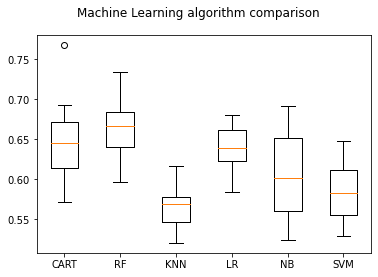

In [9]:
results = []
names   = []

for name, model in models:
    cv_results = cross_validate(model, X_train, y_train, cv=10, scoring=['accuracy', 'precision', 'recall','f1'])
    results.append(cv_results.get('test_f1'))
    names.append(name)
    
    msg = "%s \n Accuracy: %f \n Precision: %f \n Recall: %f \n F1: %f \n score_time: %f \n fit_time: %f" % (name, cv_results.get('test_accuracy').mean(), 
                                     cv_results.get('test_precision').mean(),
                                     cv_results.get('test_recall').mean(),
                                     cv_results.get('test_f1').mean(),
                                     cv_results.get('score_time').mean(),
                                     cv_results.get('fit_time').mean())   
    
    print(msg)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

En este vistazo un poquito más detallado, podemos ver que existen ciertas diferencias entre ellos, tales como los valores de las métricas de clasificación, variabilidad, o diferencias en tiempo para su cómputo.

Después de esta prueba inicial, realizaremos algunas operaciones para continuar analizando nuestros modelos y ver si podemos conseguir que mejore nuestra clasificación.

Para empezar, **normalizamos los valores de nuestros datos** (tarea 2).

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_feature = scaler.fit_transform(train_features)
scaled_test_feature = scaler.fit_transform(test_features)

In [12]:
# Scaled data
X_train = scaled_train_feature
y_train = train_labels
X_test = scaled_test_feature
y_test = test_labels

CART 
 Accuracy: 0.648667 
 Precision: 0.649678 
 Recall: 0.652000 
 F1: 0.649754 
 score_time: 0.003204 
 fit_time: 0.265196
RF 
 Accuracy: 0.676000 
 Precision: 0.708930 
 Recall: 0.602667 
 F1: 0.650287 
 score_time: 0.005198 
 fit_time: 0.096895
KNN 
 Accuracy: 0.646667 
 Precision: 0.654450 
 Recall: 0.618667 
 F1: 0.634551 
 score_time: 0.237702 
 fit_time: 0.141401
LR 
 Accuracy: 0.744667 
 Precision: 0.761567 
 Recall: 0.713333 
 F1: 0.736194 
 score_time: 0.002397 
 fit_time: 0.056200
NB 
 Accuracy: 0.567333 
 Precision: 0.648235 
 Recall: 0.293333 
 F1: 0.401930 
 score_time: 0.003502 
 fit_time: 0.022501
SVM 
 Accuracy: 0.746000 
 Precision: 0.759579 
 Recall: 0.722667 
 F1: 0.739957 
 score_time: 0.120210 
 fit_time: 1.143999


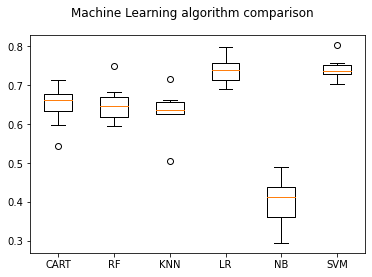

In [13]:
results = []
names   = []

for name, model in models:
    cv_results = cross_validate(model, X_train, y_train, cv=10, scoring=['accuracy', 'precision', 'recall','f1'])
    results.append(cv_results.get('test_f1'))
    names.append(name)
    
    msg = "%s \n Accuracy: %f \n Precision: %f \n Recall: %f \n F1: %f \n score_time: %f \n fit_time: %f" % (name, cv_results.get('test_accuracy').mean(), 
                                     cv_results.get('test_precision').mean(),
                                     cv_results.get('test_recall').mean(),
                                     cv_results.get('test_f1').mean(),
                                     cv_results.get('score_time').mean(),
                                     cv_results.get('fit_time').mean())   
    
    print(msg)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Como podemos observar, simplemente con esa sencilla operación, alguno de nuestros clasificadores tienen una mejora considerable.

Aunque por otro lado, por ejemplo NB (Gaussian), ha bajado.

Para nuestro estudio seleccionaremos el modelo que más ha mejorado (KNN), el que más ha bajado (NB) y uno de los mejores F1 (SVM).

### 4.1. KNN

Para el estudio de KNN, con el objetivo de conseguir una mejora, comenzaremos con su hiperparámetro más conocido -> k

In [14]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
cv_scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='f1')
print('F1 mean: {}'.format(np.mean(cv_scores)))

F1 mean: 0.6182928885428567


In [15]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)
cv_scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='f1')
print('F1 mean: {}'.format(np.mean(cv_scores)))

F1 mean: 0.6350847678036315


In [16]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)
cv_scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='f1')
print('F1 mean: {}'.format(np.mean(cv_scores)))

F1 mean: 0.6474904967843305


In [17]:
knn = KNeighborsClassifier(n_neighbors=21)
knn.fit(X_train, y_train)
cv_scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='f1')
print('F1 mean: {}'.format(np.mean(cv_scores)))

F1 mean: 0.6596285749443306


In [18]:
knn = KNeighborsClassifier(n_neighbors=51)
knn.fit(X_train, y_train)
cv_scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='f1')
print('F1 mean: {}'.format(np.mean(cv_scores)))

F1 mean: 0.6490959161640232


Tras estas 5 pruebas, observamos que **nuestro modelo ha mejorado un poco**, pero tampoco excesivamente. Y aparentemente esta mejora estaba empezando a frenar.

Por tanto, pasamos al estudio de otro de sus **otros parámetros, la función de pesos**.
Por defecto esta función es 'uniform', por lo que haremos una prueba basándonos en las distancias entre elementos.

In [19]:
knn = KNeighborsClassifier(n_neighbors=21, weights='distance')
knn.fit(X_train, y_train)
cv_scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='f1')
print('F1 mean: {}'.format(np.mean(cv_scores)))

F1 mean: 0.6579316457793136


Sin ser una gran mejora, este cambio también ha ayudado a nuestro modelo a subir 1 punto. 

Vayamjos con el **siguiente parámetro -> algorithm**.

Probaremos las 3 opciones restantes a 'auto' que nos presenta este parámetro para definir el algoritmo a utilizar.

In [20]:
knn = KNeighborsClassifier(n_neighbors=51, weights='distance', algorithm='ball_tree')
knn.fit(X_train, y_train)
cv_scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='f1')
print('F1 mean: {}'.format(np.mean(cv_scores)))

F1 mean: 0.6521347742564475


In [21]:
knn = KNeighborsClassifier(n_neighbors=51, weights='distance', algorithm='kd_tree')
knn.fit(X_train, y_train)
cv_scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='f1')
print('F1 mean: {}'.format(np.mean(cv_scores)))

F1 mean: 0.6521347742564475


In [22]:
knn = KNeighborsClassifier(n_neighbors=51, weights='distance', algorithm='brute')
knn.fit(X_train, y_train)
cv_scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='f1')
print('F1 mean: {}'.format(np.mean(cv_scores)))

F1 mean: 0.6521347742564475


Podemos observar, que en este caso los resultados son idénticos para las diferentes opciones.
Aún así, probaremos como afecta **leaf_size** para BallTree (también aplicable para KDTree)

In [23]:
knn = KNeighborsClassifier(n_neighbors=51, weights='distance', algorithm='ball_tree', leaf_size=10)
knn.fit(X_train, y_train)
cv_scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='f1')
print('F1 mean: {}'.format(np.mean(cv_scores)))

F1 mean: 0.6521347742564475


In [24]:
knn = KNeighborsClassifier(n_neighbors=51, weights='distance', algorithm='ball_tree', leaf_size=100)
knn.fit(X_train, y_train)
cv_scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='f1')
print('F1 mean: {}'.format(np.mean(cv_scores)))

F1 mean: 0.6521347742564475


Donde podemos ver, que tanto para valores superiores, como inferiores, no hemos tenido ningún cambio en nuestro caso de uso.

A continuación, modificaremos los valores de **p** y **metric**.
Por defecto, se utiliza la generalización de 'minkowski' como métrica con p=2 (distancia Euclídea).
Para nuestra prueba seleccionaremos p=1 (manhattan) y p=3. 

Durante alguna de estas pruebas, se percibe como el tiempo de ejecución incrementa considerablemente, por lo que realizaremos un pequeño control de dicho tiempo.

In [25]:
init = round(time.time() * 1000)
knn = KNeighborsClassifier(n_neighbors=51, weights='distance', p=1)
knn.fit(X_train, y_train)
cv_scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='f1')
print('F1 mean: {}'.format(np.mean(cv_scores)))
end = round(time.time() * 1000)
print('Tiempo empleado: %i ms' %(end - init))

F1 mean: 0.7325263904315646
Tiempo empleado: 3760 ms


In [26]:
init = round(time.time() * 1000)
knn = KNeighborsClassifier(n_neighbors=51, weights='distance', p=3)
knn.fit(X_train, y_train)
cv_scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='f1')
print('F1 mean: {}'.format(np.mean(cv_scores)))
end = round(time.time() * 1000)
print('Tiempo empleado: %i ms' %(end - init))

F1 mean: 0.5876480603650921
Tiempo empleado: 28074 ms


En la ejecución se observa como el incremento de p requiere un coste computacional mayor -> mayor tiempo (en este caso, sin beneficio), en contraposición a p=1 que consigue un mejor resultado, aunque liviano.

Algunos de los parámetros anteriormente tratados, al igual que el anterior para p=3, hacen que nuestro modelo tenga en esta etapa de entrenamiento un costo computacional y temporal superior , que aunque en este estudio no se ha afinado, según las necesidades de nuestro problema puede ser un factor crucial.

Valores para n_neighbors, p, o incluso el algoritmo a utilizar, pueden ser algunos de estos.

Por último **n_jobs**, hace alusión al grado de paralelismo de trabajo, por lo que también está relacionado, indicando un valor de -1, seleccionaremos todos los núcleos disponibles.

In [27]:
init = round(time.time() * 1000)
knn = KNeighborsClassifier(n_neighbors=51, weights='distance', p=1, n_jobs=-1)
knn.fit(X_train, y_train)
cv_scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='f1')
print('F1 mean: {}'.format(np.mean(cv_scores)))
end = round(time.time() * 1000)
print('Tiempo empleado: %i ms' %(end - init))

F1 mean: 0.7325263904315646
Tiempo empleado: 5513 ms


In [28]:
init = round(time.time() * 1000)
knn = KNeighborsClassifier(n_neighbors=51, weights='distance', p=3, n_jobs=-1)
knn.fit(X_train, y_train)
cv_scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='f1')
print('F1 mean: {}'.format(np.mean(cv_scores)))
end = round(time.time() * 1000)
print('Tiempo empleado: %i ms' %(end - init))

F1 mean: 0.5876480603650921
Tiempo empleado: 9453 ms


En las anteriores celdas, vemos como para valores de p superiores, el ahorro gracias al paralelismo es considerable.

Como último punto de KNN, buscaremos el ajuste de algunos de estos parámetros anteriores a través de **GridSearch**, de manera automatizada.

Mantenemos el paralelismo puesto que para p=1 nos da un tiempo similar, y en el resto de caso, supone una mejora.

### GridSearch

In [29]:
init = round(time.time() * 1000)
knn = KNeighborsClassifier(n_jobs=-1)
param_grid = {'n_neighbors': ([3, 5, 7, 21, 51, 101]),
              'weights': ('uniform', 'distance'),
              'p': np.arange(1, 4)}

knn_gscv = GridSearchCV(knn, param_grid, cv=5, scoring='f1')
knn_gscv.fit(X_train, y_train)
#print(knn_gscv.score(X_test, y_test))
end = round(time.time() * 1000)
print('Tiempo empleado: %i ms' %(end - init))
knn_gscv.best_params_

Tiempo empleado: 135003 ms


{'n_neighbors': 51, 'p': 1, 'weights': 'distance'}

Arriba podemos ver la combinación de parámetros que nos indica GridSearch como óptima en función de la métrica que le hemos indicado (F1).

También hemos controlado el tiempo, puesto que esta función recorre todas las posibilidades para darnos la mejor solución, por lo que un número excesivo de parámetros y posibilidades puede hacer que este tiempo sea gigantesco.

In [30]:
knn_model = KNeighborsClassifier(n_neighbors=51, weights='distance', p=1, n_jobs=-1)
knn_model.fit(X_train, y_train)
#cv_scores = cross_val_score(knn_model, X_train, y_train, cv=10, scoring='f1')
#print('F1 mean: {}'.format(np.mean(cv_scores)))

KNeighborsClassifier(n_jobs=-1, n_neighbors=51, p=1, weights='distance')

Por último, creamos y entrenamos nuestro modelo KNN con estos parámetros para la evaluación final junto a otros modelos.

### 4.2. Support Vector Machine

En primer lugar, tras explorar las opciones facilitadas por sklearn (nuSVC y LinearSVC), he optado por realizar el estudio únicamente a través de la clase genérica SVC. 

Como nuestra matriz de datos de entrada no es cuadrada, descartamos la opción 'precomputed', puesto que esta característica es una necesidad para el kernel.

In [31]:
# create all the machine learning models
svm_models = []
svm_models.append(('linear', SVC(kernel='linear')))
svm_models.append(('poly', SVC(kernel='poly')))
svm_models.append(('rbf', SVC()))#rbf por defecto
svm_models.append(('sigmoid', SVC(kernel='sigmoid')))
#svm_models.append(('precomputed', SVC(kernel='precomputed')))

linear 
 Accuracy: 0.753333 
 Precision: 0.770675 
 Recall: 0.724000 
 F1: 0.745920 
 score_time: 0.097612 
 fit_time: 0.970396 

poly 
 Accuracy: 0.750667 
 Precision: 0.771662 
 Recall: 0.714667 
 F1: 0.741342 
 score_time: 0.110985 
 fit_time: 1.054918 

rbf 
 Accuracy: 0.746000 
 Precision: 0.759579 
 Recall: 0.722667 
 F1: 0.739957 
 score_time: 0.115307 
 fit_time: 1.099904 

sigmoid 
 Accuracy: 0.730667 
 Precision: 0.752796 
 Recall: 0.688000 
 F1: 0.718175 
 score_time: 0.121186 
 fit_time: 1.151127 



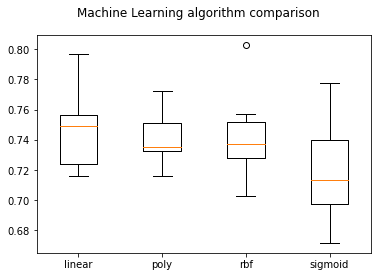

In [32]:
svm_results = []
svm_names   = []

for name, model in svm_models:
    cv_results = cross_validate(model, X_train, y_train, cv=10, scoring=['accuracy', 'precision', 'recall','f1'])
    svm_results.append(cv_results.get('test_f1'))
    svm_names.append(name)
    
    msg = "%s \n Accuracy: %f \n Precision: %f \n Recall: %f \n F1: %f \n score_time: %f \n fit_time: %f \n" % (name, cv_results.get('test_accuracy').mean(), 
                                     cv_results.get('test_precision').mean(),
                                     cv_results.get('test_recall').mean(),
                                     cv_results.get('test_f1').mean(),
                                     cv_results.get('score_time').mean(),
                                     cv_results.get('fit_time').mean())   
    
    print(msg)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
plt.boxplot(svm_results)
ax.set_xticklabels(svm_names)
plt.show()

Como podemos observar, para nuestro caso, las opciones **'linear' 'poly'** y **'rbf'** son las más interesantes, por lo que serán estas el objeto de nuestro estudio a través de GridSearch.

In [33]:
svm_model = SVC()
param_grid = {'C': np.arange(0.8, 1.5, 0.2),
              'kernel': ('linear','poly','rbf'),
              'degree':np.arange(1,6,2)}

init = round(time.time() * 1000)
svm_c_gscv = GridSearchCV(svm_model, param_grid, cv=5)
svm_c_gscv.fit(X_train, y_train)
end = round(time.time() * 1000)
print('Tiempo empleado: %i ms' %(end - init))
svm_c_gscv.best_params_

Tiempo empleado: 186039 ms


{'C': 1.0, 'degree': 1, 'kernel': 'linear'}

In [34]:
svm_model = SVC(kernel = 'linear')
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=10, scoring='f1')
print('F1 mean: {}'.format(np.mean(cv_scores)))

F1 mean: 0.7459195319685874


Del mismo modo que hemos reseñado anteriormente, el coste computacional es algo muy a tener en cuenta.

Al haber obtenido como mejores parámetros {'C': 1.0, 'degree': 1, 'kernel': 'linear'}, aunque degree es ignorado, partiremos desde ahí para comenzar a explorar algunos otros. 

Por ejemplo: **decision_function_shape**='ovo'
Esta opción (one-vs-one) reemplaza a 'ovr' (one-vs-rest). Según la documentación ovo es siempre usada para clasificación multiclase, por lo que considero oportuna la prueba.

In [35]:
svm_model = SVC(kernel = 'linear', decision_function_shape='ovo')
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=10, scoring='f1')
print('F1 mean: {}'.format(np.mean(cv_scores)))

F1 mean: 0.7459195319685874


Pero aparentemente, no presenta mejora

In [36]:
svm_model = SVC(class_weight='balanced')
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=10, scoring='f1')
print('F1 mean: {}'.format(np.mean(cv_scores)))

F1 mean: 0.7399567970742376


In [37]:
svm_model = SVC(gamma='auto')
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=10, scoring='f1')
print('F1 mean: {}'.format(np.mean(cv_scores)))

F1 mean: 0.6780696229648583


Por último, **class_weight**='balanced' tampoco supone ninguna mejora 

El modo 'balanced' usa los valores de y para ajustar los pesos automáticamente de manera inversamente proporcional a la frecuencia de la clase.

In [38]:
svm_model = SVC(kernel = 'linear')
svm_model.fit(X_train, y_train)
#cv_scores = cross_val_score(svm_model, X_train, y_train, cv=10, scoring='f1')
#print('F1 mean: {}'.format(np.mean(cv_scores)))

SVC(kernel='linear')

Por último, al igual que con KNN, hemos creado nuestro SVM con estos parámetros para la evaluación final junto a otros modelos.

### 4.3. Naive Bayes

Aunque en el inicio de este notebook se ha utilizado GaussianNB para las pruebas generales, en este apartado profundizaremos inicialmente un poco más en el resto de opciones que nos proporciona sklearn.

In [39]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB

In [40]:
nb_models = {
    'GaussianNB': GaussianNB(),
    'MultinomialNB': MultinomialNB(),
    'ComplementNB': ComplementNB(),
    'BernoulliNB': BernoulliNB(),
}

GaussianNB 
 Accuracy: 0.567333 
 Precision: 0.648235 
 Recall: 0.293333 
 F1: 0.401930 
 score_time: 0.003789 
 fit_time: 0.023504 

MultinomialNB 
 Accuracy: 0.696000 
 Precision: 0.714296 
 Recall: 0.656000 
 F1: 0.682893 
 score_time: 0.002696 
 fit_time: 0.007204 

ComplementNB 
 Accuracy: 0.696000 
 Precision: 0.714296 
 Recall: 0.656000 
 F1: 0.682893 
 score_time: 0.002999 
 fit_time: 0.006501 

BernoulliNB 
 Accuracy: 0.662000 
 Precision: 0.663693 
 Recall: 0.662667 
 F1: 0.661173 
 score_time: 0.003399 
 fit_time: 0.015301 



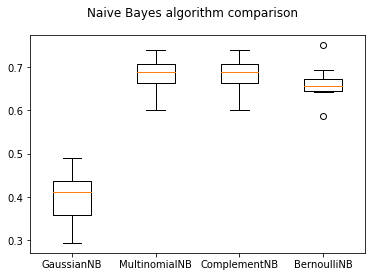

In [41]:
nb_results = []
nb_names   = []


for model_key, model_value in nb_models.items():   
    cv_results = cross_validate(model_value, X_train, y_train, cv=10, scoring=['accuracy', 'precision', 'recall','f1'])
    nb_results.append(cv_results.get('test_f1'))
    nb_names.append(model_key)
    
    msg = "%s \n Accuracy: %f \n Precision: %f \n Recall: %f \n F1: %f \n score_time: %f \n fit_time: %f \n" % (model_key, cv_results.get('test_accuracy').mean(), 
                                     cv_results.get('test_precision').mean(),
                                     cv_results.get('test_recall').mean(),
                                     cv_results.get('test_f1').mean(),
                                     cv_results.get('score_time').mean(),
                                     cv_results.get('fit_time').mean())   
    
    print(msg)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Naive Bayes algorithm comparison')
ax = fig.add_subplot(111)
plt.boxplot(nb_results)
ax.set_xticklabels(nb_names)
plt.show()



Viendo los resultados obtenidos, optamos por descartar GaussianNB.

In [42]:
del nb_models['GaussianNB']

In [43]:
# the optimisation parameters for each of the above models
nb_params = {
    'MultinomialNB':{ 
            "alpha"      : np.arange(0,1,0.1),
            "fit_prior"       : ('True', 'False')        
            },
    'ComplementNB': {
            "alpha"      : np.arange(0,1,0.1),
            "fit_prior"  : ('True', 'False'),        
            "norm"       : ('True', 'False')
        },
    'BernoulliNB': {
            "alpha"      : np.arange(0,1,0.1),
            "fit_prior"       : ('True', 'False')        
        }  
}

In [44]:
f1=0
for name in nb_models.keys():
    est = nb_models[name]
    est_params = nb_params[name]
    gscv = GridSearchCV(estimator=est, param_grid=est_params, cv=10, scoring='f1')
    gscv.fit(X_train, y_train)
    if gscv.score(X_train, y_train) > f1:
        best = gscv
        f1=gscv.score(X_train, y_train)
    print('%s F1: %f'%(gscv.best_estimator_,gscv.score(X_train, y_train)))    

MultinomialNB(alpha=0.5, fit_prior='True') F1: 0.714187
ComplementNB(alpha=0.9, fit_prior='True', norm='True') F1: 0.643879
BernoulliNB(alpha=0.9, fit_prior='True') F1: 0.679521


Al igual que en casos anteriores, seleccionamos la configuración recomendada

In [45]:
nb_model = MultinomialNB(alpha=0.5, fit_prior='True')
nb_model.fit(X_train, y_train)

MultinomialNB(alpha=0.5, fit_prior='True')

Como comentario final para este apartado sobre los métodos Bayesianos, estos cobran especial importancia cuando tenemos cierta información agregada como posibles desbalanceos o frecuencias de aparición, no siendo este el caso.

Una posible simulación de este hecho con modificación de los datos de test y entrenamiento queda pendiente para próximos estudios.

# 5. EVALUACIÓN DEL MODELADO

### Seleccionamos los modelos


KNN 
 Accuracy: 0.721333 
 Precision: 0.702689 
 Recall: 0.766667 
 F1: 0.732526 
 score_time: 0.202191 
 fit_time: 0.137062 

SVM 
 Accuracy: 0.753333 
 Precision: 0.770675 
 Recall: 0.724000 
 F1: 0.745920 
 score_time: 0.093706 
 fit_time: 0.946674 

NB 
 Accuracy: 0.697333 
 Precision: 0.713449 
 Recall: 0.662667 
 F1: 0.686025 
 score_time: 0.002794 
 fit_time: 0.006705 



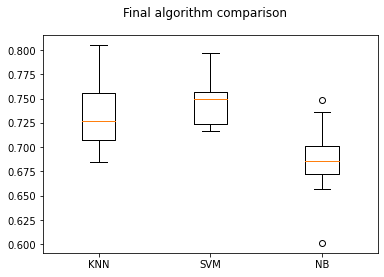

In [46]:
final_models = []

final_models.append(('KNN',knn_model))
final_models.append(('SVM',svm_model))
final_models.append(('NB',nb_model))

final_results = []
final_names   = []

for name, model in final_models:
    cv_results = cross_validate(model, X_train, y_train, cv=10, scoring=['accuracy', 'precision', 'recall','f1'])
    final_results.append(cv_results.get('test_f1'))
    final_names.append(name)
    
    msg = "%s \n Accuracy: %f \n Precision: %f \n Recall: %f \n F1: %f \n score_time: %f \n fit_time: %f \n" % (name, cv_results.get('test_accuracy').mean(), 
                                     cv_results.get('test_precision').mean(),
                                     cv_results.get('test_recall').mean(),
                                     cv_results.get('test_f1').mean(),
                                     cv_results.get('score_time').mean(),
                                     cv_results.get('fit_time').mean())   
    
    print(msg)

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Final algorithm comparison')
ax = fig.add_subplot(111)
plt.boxplot(final_results)
ax.set_xticklabels(final_names)
plt.show()

Pero estos valores, son con respecto a su entrenamiento y validación, ahora pasaremos a comprobar sobre el set de test.

In [47]:
y_pred_knn_model = knn_model.predict(X_test)
y_pred_svm_model = svm_model.predict(X_test)
y_pred_nb_model = nb_model.predict(X_test)

### Matriz de confusión


In [48]:
print("KNN")
print(confusion_matrix(y_test, y_pred_knn_model))
print("SVM")
print(confusion_matrix(y_test, y_pred_svm_model))
print("NB")
print(confusion_matrix(y_test, y_pred_nb_model))

KNN
[[67 33]
 [16 84]]
SVM
[[63 37]
 [10 90]]
NB
[[73 27]
 [22 78]]


### Informe de clasificación

In [49]:
print("KNN")
print(classification_report(y_test, y_pred_knn_model, target_names = class_label.keys()))
print("SVM")
print(classification_report(y_test, y_pred_svm_model, target_names = class_label.keys()))
print("NB")
print(classification_report(y_test, y_pred_nb_model, target_names = class_label.keys()))

KNN
                precision    recall  f1-score   support

   carrot_cake       0.81      0.67      0.73       100
chocolate_cake       0.72      0.84      0.77       100

      accuracy                           0.76       200
     macro avg       0.76      0.76      0.75       200
  weighted avg       0.76      0.76      0.75       200

SVM
                precision    recall  f1-score   support

   carrot_cake       0.86      0.63      0.73       100
chocolate_cake       0.71      0.90      0.79       100

      accuracy                           0.77       200
     macro avg       0.79      0.77      0.76       200
  weighted avg       0.79      0.77      0.76       200

NB
                precision    recall  f1-score   support

   carrot_cake       0.77      0.73      0.75       100
chocolate_cake       0.74      0.78      0.76       100

      accuracy                           0.76       200
     macro avg       0.76      0.76      0.75       200
  weighted avg       0.76    

#### ¿Esta balanceado nuestro modelo? ¿Por qué lo sabemos?
Sin ser unos valores excepcionales, los valores de precisión y recall son altos, y similares. Por lo que podemos concluir que nuestro modelo está balanceado.

### ROC / AUC


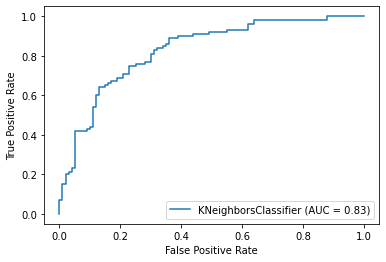

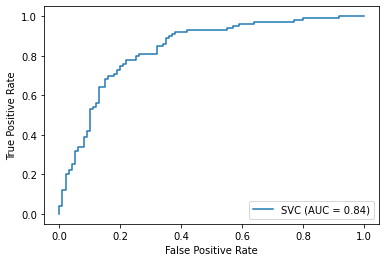

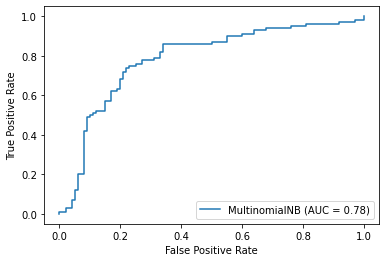

In [50]:
plot_roc_curve(knn_model, X_test, y_test)  
plot_roc_curve(svm_model, X_test, y_test)  
plot_roc_curve(nb_model, X_test, y_test)  

plt.show()        

Por último, percibimos de una manera más visual la relación entre nuestros TP y FP